In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.datasets import fashion_mnist

In [29]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import wandb
wandb.init(
    project="assignmnet 1",
)

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [30]:
fashion_mnist = keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

Download the fashion-MNIST dataset and plot 1 sample image for each class

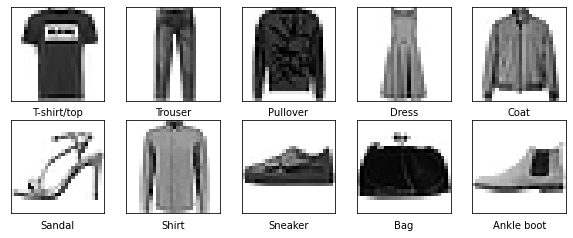

In [31]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
k=len(class_names)
images_plot,count=[],0
for i in range(len(train_images)):
  if(count>=k): break
  if(count==train_labels[i]):
    images_plot.append(train_images[i])
    count+=1

plt.figure(figsize=(10,10))
for i in range(10):
     plt.subplot(5,5,i+1)
     plt.xticks([])
     plt.yticks([])
     plt.imshow(images_plot[i], cmap=plt.cm.binary)
     plt.xlabel(class_names[i])


Implement a feedforward neural network which takes images from the fashion-mnist data as input and outputs a probability distribution over the 10 classes.



In [32]:
#flat the input
image_size=28*28
train_images_X=np.zeros(shape=(len(train_images),(28*28)),dtype='float32')  #60000x728
test_images_X=np.zeros(shape=(len(test_images),(28*28)),dtype='float32')    #10000x728

for i in range(len(train_images)):
  train_images_X[i]=train_images[i].flatten()/255
for i in range(len(test_images)):
  test_images_X[i]=test_images[i].flatten()/255

#one hot encoding 
def one_hot(i):
  y=np.zeros((10,1))
  y[i]=1
  return y


In [33]:
def sigmoid(x):
   x=x-max(x)
   return 1./(1.+np.exp(-x))

def derivative_relu(x):
  return 1 if x>0 else 0

def relu(x):
  return max(x) if max(x)>0 else 0

def softmax(x):
  x=x-max(x)
  return np.exp(x)/np.sum(np.exp(x))

def derivative_sigmoid(x):
  return sigmoid(x)*(np.ones_like(x)-sigmoid(x))

def cross_entropy(true_output,predicted_output):
  return -1.0*np.sum(true_output*np.log(predicted_output+1e-9))



In [34]:
def activation_function(funct,x,derivative=False):
  if derivative==True:
    if funct=="sigmoid":
      return derivative_sigmoid(x)
    if funct=="relu":
      return derivative_relu(x)
  
  else:
    if funct=="sigmoid":
      return sigmoid(x)
    if funct=="relu":
      return relu(x)
  

In [35]:
def init_zero(number_of_neurons,number_hidden_layers,k):
  parameters={}
  parameters['W'+str(1)]=np.zeros((number_of_neurons,image_size))
  parameters['b'+str(1)]=np.zeros((number_of_neurons,1))
  for i in range(2,number_hidden_layers+1):
    parameters['W'+str(i)]=np.zeros((number_of_neurons,number_of_neurons))
    parameters['b'+str(i)]=np.zeros((number_of_neurons,1))
  parameters['W'+str(number_hidden_layers+1)]=np.zeros((k,number_of_neurons))
  parameters['b'+str(number_hidden_layers+1)]=np.zeros((k,1))
  return parameters

def accuracy(X,y,params):
  cnt=0
  for i in range(len(X)):
    predicted_y,activation,pre_activation=feed_forward(number_hidden_layers,params,hidden_layer_size,k,X[i])
    if(np.argmax(predicted_y)==y[i]):
      cnt+=1
  print(cnt/len(X)*100)
  

In [36]:
#feed forward
def xavier_init(n_in, n_out):
    return np.random.default_rng().uniform(low=-0.69,high=0.69,size=(n_in,n_out))

def initialize_parameters(number_of_neurons,number_hidden_layers,k):
  parameters={}
  previous_parameters={}
  parameters['W'+str(1)]=xavier_init(number_of_neurons,image_size)
  parameters['b'+str(1)]=xavier_init(number_of_neurons,1)
  for i in range(2,number_hidden_layers+1):
    parameters['W'+str(i)]=xavier_init(number_of_neurons,number_of_neurons)
    parameters['b'+str(i)]=xavier_init(number_of_neurons,1)
  parameters['W'+str(number_hidden_layers+1)]=xavier_init(k,number_of_neurons)
  parameters['b'+str(number_hidden_layers+1)]=xavier_init(k,1)
  return parameters




In [37]:
def update_parameters(parameters,gradient_change,learning_rate):
  for i in range(1,len(parameters)//2+1):
    parameters['W'+str(i)]=parameters['W'+str(i)]-learning_rate*gradient_change['W'+str(i)]
    parameters['b'+str(i)]=parameters['b'+str(i)]-learning_rate*gradient_change['b'+str(i)]
  return parameters

def update_parameters_momentum(parameters,gradient_change,prior_updates,beta,learning_rate):
  for i in range(1,len(parameters)//2+1):
    prior_updates['W'+str(i)]=beta*prior_updates['W'+str(i)]+gradient_change['W'+str(i)]
    parameters['W'+str(i)]=parameters['W'+str(i)]-learning_rate*prior_updates['W'+str(i)]

    prior_updates['b'+str(i)]=beta*prior_updates['b'+str(i)]+gradient_change['b'+str(i)]
    parameters['b'+str(i)]=parameters['b'+str(i)]-learning_rate*prior_updates['b'+str(i)]
  return parameters,prior_updates

def update_parameters_rmsprop(parameters,gradient_change,prior_updates,learning_rate,beta,batch_size):
  epsilon=1e-9
  for i in range(1,len(parameters)//2+1):
    prior_updates['W'+str(i)]=beta*prior_updates['W'+str(i)]+(1-beta)*(gradient_change['W'+str(i)])**2
    parameters['W'+str(i)]=parameters['W'+str(i)]-gradient_change['W'+str(i)]*(learning_rate/np.sqrt(prior_updates['W'+str(i)]+epsilon))

    prior_updates['b'+str(i)]=beta*prior_updates['b'+str(i)]+(1-beta)*(gradient_change['b'+str(i)])**2
    parameters['b'+str(i)]=parameters['b'+str(i)]-gradient_change['b'+str(i)]*(learning_rate/np.sqrt(prior_updates['b'+str(i)]+epsilon))
  return parameters,prior_updates


In [38]:
def feed_forward(number_hidden_layers,parameters,hidden_layer_size,k,data):
  activation={}
  pre_activation={}

  activation['h0']=data.reshape(784,1)
  for i in range(1,number_hidden_layers+1):
    a=np.add(parameters['b'+str(i)],np.matmul(parameters['W'+str(i)],activation['h'+str(i-1)]))
    h=sigmoid(a)
    pre_activation['a'+str(i)]=a
    activation['h'+str(i)]=h
  
  a=np.add(parameters['b'+str(number_hidden_layers+1)],np.matmul(parameters['W'+str(number_hidden_layers+1)],activation['h'+str(number_hidden_layers)]))
  h=softmax(a)
  pre_activation['a'+str(number_hidden_layers+1)]=a
  activation['h'+str(number_hidden_layers+1)]=h
  
  return h,activation,pre_activation



In [39]:
#h:: activation a=:preactivation
def back_propogation(parameters,activation,pre_activation,X,y,number_hidden_layers,predicted_y,k):

  gradient_parameters,gradient_activation,gradient_preactivation={},{},{}

  #compute output gradient
  e_y=np.zeros((k,1))
  e_y[y][0]=1
  gradient_preactivation['a'+str(number_hidden_layers+1)]=-(e_y-predicted_y)

  for t in range(number_hidden_layers+1,0,-1):
    #compute gradients w.r.t parameters
    gradient_parameters['W'+str(t)]=np.matmul(gradient_preactivation['a'+str(t)],activation['h'+str(t-1)].T)
    gradient_parameters['b'+str(t)]=gradient_preactivation['a'+str(t)]
    #print(t,gradient_parameters['W'+str(t)])
    if(t==1):break
    #compute gradients w.r.t layers below
    gradient_activation['h'+str(t-1)]=np.matmul(parameters['W'+str(t)].T,gradient_preactivation['a'+str(t)])

    #compute gradients w.r.t preactivation layer
    gradient_preactivation['a'+str(t-1)]=np.multiply(gradient_activation['h'+str(t-1)],activation_function("sigmoid",pre_activation['a'+str(t-1)],True))
  #print(pre_activation)
  return gradient_parameters

In [40]:
def gradient_descent(number_hidden_layers,hidden_layer_size,batch_size,max_epochs,X,y,k,optimizer,learning_rate,beta):
  parameters=initialize_parameters(hidden_layer_size,number_hidden_layers,k)
  for epoch in range(max_epochs):
    loss=0
    cnt=0
    for i in range(len(X)):
      predicted_y,activation,pre_activation=feed_forward(number_hidden_layers,parameters,hidden_layer_size,k,X[i])
      #print(activation['h4'])
      
      loss+=cross_entropy(one_hot(train_labels[i]),predicted_y)
      gradient_parameters=back_propogation(parameters,activation,pre_activation,X[i],y[i],number_hidden_layers,predicted_y,k)
      if( epoch==0 and i==0 and (optimizer=='momentum' or optimizer=='rmsprop')):
        prior_updates=init_zero(hidden_layer_size,number_hidden_layers,k)

      if(cnt==0):
        gradient_change={}
        gradient_change=gradient_parameters.copy()

      else:
        for iter in range(1,len(parameters)//2+1):
          gradient_change['W'+str(iter)]+=gradient_parameters['W'+str(iter)]
          gradient_change['b'+str(iter)]+=gradient_parameters['b'+str(iter)]
      cnt+=1
      
      if(cnt%batch_size==0 or i==len(X)-1):
        t=cnt if (i==len(X)-1) else batch_size
        for it in range(1,len(parameters)//2+1):
          gradient_change['W'+str(it)]=gradient_change['W'+str(it)]/t
          gradient_change['b'+str(it)]=gradient_change['b'+str(it)]/t
        cnt=0
        if(optimizer=='sgd'):
          parameters=update_parameters(parameters,gradient_change,learning_rate)
        elif(optimizer=='momentum'):
          parameters,prior_updates=update_parameters_momentum(parameters,gradient_change,prior_updates,learning_rate,beta)
        elif(optimizer=='rmsprop'):
          parameters,prior_updates=update_parameters_rmsprop(parameters,gradient_change,prior_updates,learning_rate,beta,t)
        
    print(epoch,loss/len(X))
  return parameters

In [ ]:

def gradient_descent_adam(number_hidden_layers,hidden_layer_size,batch_size,max_epochs,X,y,k,optimizer,learning_rate,beta):
  beta1=0.9
  beta2=0.99
  parameters=initialize_parameters(hidden_layer_size,number_hidden_layers,k)
  momentum=init_zero(hidden_layer_size,number_hidden_layers,k)
  momentum_hat=init_zero(hidden_layer_size,number_hidden_layers,k)
  update=init_zero(hidden_layer_size,number_hidden_layers,k)
  update_hat=init_zero(hidden_layer_size,number_hidden_layers,k)

  for epoch in range(max_epochs):
    loss=0
    cnt=0
    epsilon=1e-9
    for i in range(len(X)):
      predicted_y,activation,pre_activation=feed_forward(number_hidden_layers,parameters,hidden_layer_size,k,X[i])
      #print(activation['h4'])
      loss+=cross_entropy(one_hot(train_labels[i]),predicted_y)
      gradient_parameters=back_propogation(parameters,activation,pre_activation,X[i],y[i],number_hidden_layers,predicted_y,k)
      if(cnt==0):
        gradient_change={}
        gradient_change=gradient_parameters.copy()

      else:
        for iter in range(1,len(parameters)//2+1):
          gradient_change['W'+str(iter)]+=gradient_parameters['W'+str(iter)]
          gradient_change['b'+str(iter)]+=gradient_parameters['b'+str(iter)]
      cnt+=1
      
      if(cnt%batch_size==0 or i==len(X)-1):
        t=cnt if (i==len(X)-1) else batch_size
        for it in range(1,len(parameters)//2+1):
          gradient_change['W'+str(it)]=gradient_change['W'+str(it)]/t
          gradient_change['b'+str(it)]=gradient_change['b'+str(it)]/t
        
        cnt=0
        for it in range(1,len(parameters)//2+1):
          momentum['W'+str(it)]=beta1*momentum['W'+str(it)]+(1-beta1)*gradient_change['W'+str(it)]
          momentum['b'+str(it)]=beta1*momentum['b'+str(it)]+(1-beta1)*gradient_change['b'+str(it)]
          momentum_hat['W'+str(it)]=momentum['W'+str(it)]/(1-beta1**(epoch+1))
          momentum_hat['b'+str(it)]=momentum['b'+str(it)]/(1-beta1**(epoch+1))

        for it in range(1,len(parameters)//2+1):
          update['W'+str(it)]=beta2*update['W'+str(it)]+(1-beta2)*gradient_change['W'+str(it)]**2
          update['b'+str(it)]=beta2*update['b'+str(it)]+(1-beta2)*gradient_change['b'+str(it)]**2
          update_hat['W'+str(it)]=update['W'+str(it)]/(1-beta2**(epoch+1))
          update_hat['b'+str(it)]=update['b'+str(it)]/(1-beta2**(epoch+1))

        if(optimizer=='adam'):
          for it in range(1,len(parameters)//2+1):
            parameters['W'+str(it)]=parameters['W'+str(it)]-(learning_rate*momentum_hat['W'+str(it)]/np.sqrt(update_hat['W'+str(it)]+epsilon))
            parameters['b'+str(it)]=parameters['b'+str(it)]-(learning_rate*momentum_hat['b'+str(it)]/np.sqrt(update_hat['b'+str(it)]+epsilon))
        else:
          for it in range(1,len(parameters)//2+1):
            parameters['W'+str(it)]=parameters['W'+str(it)]-(learning_rate/np.sqrt(update_hat['W'+str(it)]+epsilon))*(beta1*momentum_hat['W'+str(it)]+(1-beta1)*gradient_change['W'+str(it)])
            parameters['b'+str(it)]=parameters['b'+str(it)]-(learning_rate/np.sqrt(update_hat['b'+str(it)]+epsilon))*(beta1*momentum_hat['b'+str(it)]+(1-beta1)*gradient_change['b'+str(it)])
          
      
          
    print(epoch,loss/len(X))
  return parameters


In [ ]:
number_hidden_layers=3
hidden_layer_size=128
batch_size=32
max_epochs=1
k=10
optimizer='rmsprop'
learning_rate=0.01
beta=0.9
params=gradient_descent(number_hidden_layers,hidden_layer_size,batch_size,max_epochs,train_images_X,train_labels,k,optimizer,learning_rate,beta)

In [ ]:
print(accuracy(train_images_X,train_labels,params))

In [ ]:
print(accuracy(test_images_X,test_labels,params))